In [1]:
# Packages
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Atmosphere parameters
Cn2_h0 = 1e-17       # baseline Cn^2 [m^(-2/3)] (weak: 1e-17, strong: 1e-12)
V = 23           # visibility [km]
vG = 5.0            # ground wind [m/s] (weak: 5, strong: 10)
vT = 20.0            # tropopause wind [m/s] (weak: 20, strong: 30)
HT = 10000.0         # tropopause height [m]
LT = 1000.0          # tropopause thickness [m]
M = 1                # turbulence scaling
RE = 6370e3          # Earth radius [m]
phi = np.deg2rad(90)    # angle between the wind direction and the zenith

# Satellite parameters
h = 300e3            # satellite altitude [m]
zeta = np.deg2rad(30)  # zenith angle

# Receiver parameters 
hg = 100             # ground elevation above sea level [m]
h0 = 10

# Candidate operational parameters 
lambdas = [810e-9, 1064e-9, 1550e-9]    # wavelengths [nm] (lambda)
beam_waists = [0.005, 0.05, 0.1]        # initial beam waists [m] (w0)
station_heights = [0, 10, 20]           # ground station heights [m] (h)

# Detector/QKD parameters
eta_QE = 0.7        # quantum efficiency
Delta_lambda_nm = 1.0   # wavelength filter[nm]
Delta_lambda = Delta_lambda_nm * 1e-9   # [m]
dt = 1e-9               # integration time [s]
H_sky = 1e-6            # spectral sky radiance [W/m^2/sr/nm] for 1550 nm at night
DCR = 100           # dark count rate [s^-1]



In [2]:
# Kim model 
def p_func(V):
    """Gives the exponent p in the Kim model based on visibility V [km]"""
    if V > 50: return 1.6
    elif 6 <= V <= 50: return 1.3
    elif 1 <= V < 6: return 0.16 * V + 0.34
    elif 0.5 <= V < 1: return V - 0.5
    elif V < 0.5: return 0
    
def binary_entropy(x):
    if x <= 0 or x >= 1:
        return 0
    return -x*np.log2(x) - (1-x)*np.log2(1-x)

In [ ]:
def run_case(lam, w0, aR):
    b = (1/3) * aR      # second mirror radius [m]
    
    # Physical constants
    hP = 6.626e-34   # Planck's constant [Js]
    c = 3e8           # speed of light [m/s]
    Eph = hP*c/lam    # photon energy [J]

    # Slant lengths
    L = np.sqrt((RE + h)**2 + (RE + h0)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0) * np.cos(zeta)
    L_atm = np.sqrt((RE + HT)**2 + (RE + h0)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0) * np.cos(zeta)


    def v_profile(hh, zeta):
        bracket = np.sqrt(np.sin(phi)**2 + (np.cos(phi)**2) * (np.cos(zeta)**2))
        return vG + vT * np.exp(-(((hh + hg) * np.cos(zeta) - HT) / LT)**2) * bracket
    
    def Cn2_profile(hh, h0, Cn2_h0):
        vhh = v_profile(hh, zeta)
        term1 = 1.04e-3 * (9.0 / vhh)**2 * ((hh + hg)/1e5)**10 * np.exp(-(hh+hg)/1200.0)
        term2 = 2.7e-16 * np.exp(-(hh+hg)/1700.0)
        term3 = Cn2_h0 * (h0 / (hh + 1e-9))**(4/3)
        return M * (term1 + term2) + term3
    integral_Cn2, _ = quad(lambda hh: Cn2_profile(hh, h0, Cn2_h0), h0, HT)
    r0 = (0.423 * (2*np.pi/lam)**2 * (1/np.cos(zeta)) * integral_Cn2)**(-3/5)
    Omega_fov = np.pi*(1.22*(lam/(2*aR))*(1+((2*aR)/r0)**(5/3))**(3/5))**2

    # QKD protocol
    q = 0.5
    e_det = 0.015
    mu = 0.1
    fEC = 1.22

    # Extinction coefficient gamma
    p = p_func(V)
    gamma = ((3.91 / V) * (lam * 1e9 / 550) ** (-p)) / 1000.0

    # Weather transmittance
    L_atm = np.sqrt((RE + HT)**2 + (RE + h0)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0) * np.cos(zeta)
    eta_weather = np.exp(-gamma * L_atm)

    # Beam diffraction-limited radius
    w_L = w0 * np.sqrt(1 + (lam * L / (np.pi * w0**2))**2)

    integral_Ry2, _ = quad(lambda hh: (hh - h0)**(5/6) * Cn2_profile(hh, h0, Cn2_h0),
                       h0, HT)
    sigma_Ry2 = 2.25 * (2*np.pi/lam)**(7/6) * (1/np.cos(zeta))**(11/6) * integral_Ry2
    Lambda = 2*L / ((2*np.pi/lam) * w_L**2)
    w_LT = w_L * np.sqrt(1 + 1.63 * (sigma_Ry2**(6/5)) * Lambda)

    eta_lt = np.exp(-2 * b**2 / (w_LT**2)) - np.exp(-2 * aR**2 / (w_LT**2))


    S = (1+((2*aR)/r0)**(5/3))**(-6/5)
    eta_coupling = (S*74+1.84)/100

    eta_eff =  eta_coupling * eta_QE
    eta_tot = eta_weather * eta_lt * eta_eff

    Delta_lambda_nm = 1.0 
    p_sig = mu * eta_tot
    hP = 6.626e-34; c = 3e8
    A_tel = np.pi * aR**2
    Eph = hP * c / lam
    p_bg = H_sky * Delta_lambda_nm * Omega_fov * A_tel * dt / Eph

    p_dark = DCR * dt
    p_det = p_sig + p_bg + p_dark

    Q = (e_det * p_sig + 0.5 * (p_bg + p_dark)) / p_det
    R = q * (-p_det * fEC * binary_entropy(Q) + mu * eta_tot * np.exp(-mu) * (1 - binary_entropy(Q)))

    return Q, R



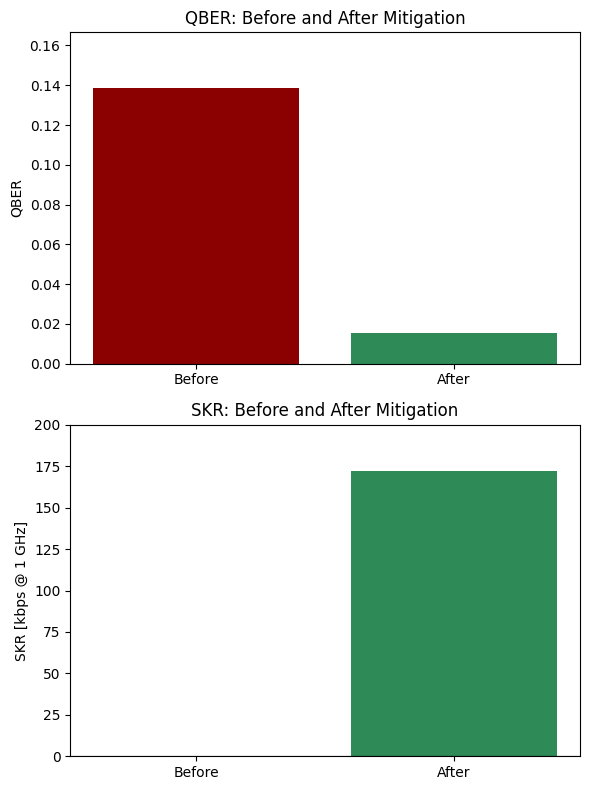

In [4]:
# CASES (Before vs After mitigation)
Q_before, R_before = run_case(810e-9, 0.005, 0.1)   # before mitigation
Q_after, R_after   = run_case(1550e-9, 0.1, 0.35)     # after mitigation (original)

# SKR to kbps at 1 GHz
clock_rate = 1e9  # 1 GHz [pulses/s]
def normalize_skr(R_bits_per_pulse):
    return R_bits_per_pulse * clock_rate / 1e3  # converting to kbps

# Normalized SKR values
R_before_kbps = normalize_skr(R_before)
R_after_kbps  = normalize_skr(R_after)

# Plot 
labels = ["Before", "After"]

fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# QBER bar chart
axes[0].bar(labels, [Q_before, Q_after], color=["darkred", "seagreen"])
axes[0].set_ylabel("QBER")
axes[0].set_title("QBER: Before and After Mitigation")
axes[0].set_ylim(0, max(Q_before, Q_after)*1.2)

# SKR bar chart (normalized to kbps @ 1 GHz)
axes[1].bar(labels, [R_before_kbps, R_after_kbps], color=["darkred", "seagreen"])
axes[1].set_ylabel("SKR [kbps @ 1 GHz]")
axes[1].set_title("SKR: Before and After Mitigation")
axes[1].axhline(y=0, color="black", linewidth=0.8)
axes[1].set_ylim(0, 200)

plt.tight_layout()
plt.show()